# 쇼핑몰 지점별 매출액 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style='white')

In [3]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측\\쇼핑몰지점별-매출액-EDA모델링'

In [4]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측')

In [5]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [6]:
df.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

## 데이터 전처리 및 파생변수 생성

- Data 변수를 날짜 형식으로 변경하여 연, 월, 일 변수를 생성

`-` 또한 2010년을 기준으로 연월일을 하루 단위로 변환하여 2010년으로부터 며칠이 지났는지를 알 수 있는 변수를 생성하겠다  

In [7]:
def get_date(df) -> None:
    """df['Date']에서 연, 월, 일 변수를 생성""" 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

In [8]:
get_date(df)
get_date(test)

In [9]:
df['Day_Range'] = (df['Date'] - pd.datetime(2010, 1, 1)).dt.days
test['Day_Range'] = (test['Date'] - pd.datetime(2010, 1, 1)).dt.days

- 공휴일 변수를 숫자로 변경

In [10]:
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x else 0)

- 프로모션의 결측치를 $-1$로 대체

In [11]:
df.fillna(value=-1, inplace=True)
test.fillna(value=-1, inplace=True)

- 총 프로모션 비용 변수 생성

In [12]:
df['Promotion_Cost'] = df[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)
test['Promotion_Cost'] = test[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)

- month의 몇 번재 week인지 나타내는 변수 생성

In [13]:
df['WeekOfMonth'] = df['Day'].apply(lambda x: (x-1) // 7 + 1)
test['WeekOfMonth'] = test['Day'].apply(lambda x: (x-1) // 7 + 1)

- 크리스마스가 몇 주일 남았는지 나타내는 변수를 생성

`-` 크리스마스는 12월 4주차에 존재함

`-` 12월 3주차는 2, 4주차는 3, 5주차는 1, 그 외는 0으로 코딩 (매출액이 기준)

In [14]:
def christmas_week(date):
    month = date.month
    week_of_month = (date.day-1) // 7 + 1
    if month == 12:
        if week_of_month == 3:
            return 2
        elif week_of_month == 4:
            return 3
        elif week_of_month == 5:
            return 1
    return 0

In [15]:
df['IsChristmasWeek'] = df['Date'].apply(lambda date: christmas_week(date))
test['IsChristmasWeek'] = test['Date'].apply(lambda date: christmas_week(date))

In [16]:
df.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Day,Day_Range,Promotion_Cost,WeekOfMonth,IsChristmasWeek
0,1,2010-05-02,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1643690.90,2010,5,2,121,-5.0,1,0
1,1,2010-12-02,38.51,2.548,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,1,1641957.44,2010,12,2,335,-5.0,1,0
2,1,2010-02-19,39.93,2.514,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1611968.17,2010,2,19,49,-5.0,3,0
3,1,2010-02-26,46.63,2.561,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1409727.59,2010,2,26,56,-5.0,4,0
4,1,2010-05-03,46.50,2.625,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1554806.68,2010,5,3,122,-5.0,1,0


- 쇼핑몰 지점 군집화

In [70]:
cor_list = []
for store in list(range(1, 46)):
    df_ = df.query('Store == @store')
    cor = np.corrcoef(df_['Day_Range'], df_['Weekly_Sales'])[1, 0]
    cor_list.append(cor)

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Count'>

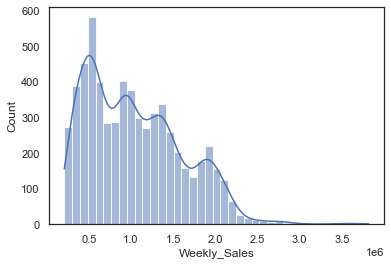

In [49]:
sns.histplot(data=df, x='Weekly_Sales', kde=True)

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

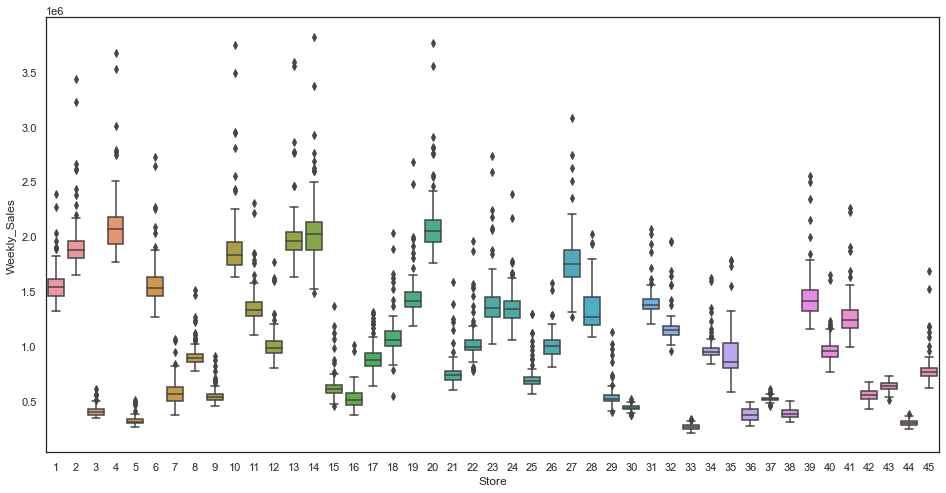

In [21]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, y='Weekly_Sales', x='Store')

`-` 비슷한 분포를 띄는 쇼핑몰 지점을 군집화하자 (매출액의 중앙값과 IQR, 지난 일수와의 상관계수가 비슷해야 함)

In [44]:
tmp = df.groupby(by='Store').agg({'Weekly_Sales':[np.median, lambda x: np.quantile(x, q=0.75) - np.quantile(x, q=0.25)]}).\
        reset_index().rename(columns={'<lambda_0>':'IQR'}).melt(id_vars='Store').\
        rename(columns={'variable_1':'statistic'}).drop('variable_0', axis=1)

<AxesSubplot:>

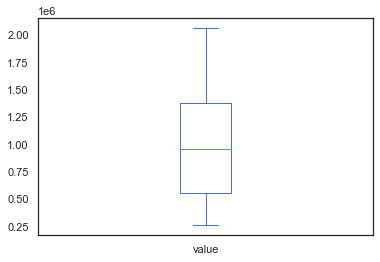

In [45]:
tmp.query('statistic == "median"').value.plot.box()

<AxesSubplot:>

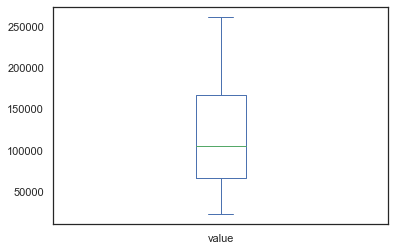

In [46]:
tmp.query('statistic == "IQR"').value.plot.box()

`-` 매출액의 중앙값과 사분위수 범위가 비슷한 쇼핑몰 지점끼리 군집화하겠다

`-` 나의 능지 문제로 일단은 일일이 분류하겠다

`-` 나중에 함수로 만들든 클래스로 만들든 해가지고 이를 사용해 분류하겠다


In [47]:
median_bins = [-np.inf]
for i in range(1, 8):
    value = np.quantile(tmp.query('statistic == "median"').value, q=i/8)
    median_bins.append(value)
median_bins.append(np.inf)

In [48]:
cuts = pd.cut(tmp.query('statistic == "median"').value, bins=median_bins, labels=list(range(1, 9)))

In [49]:
store_df = pd.DataFrame(data=range(1, 46), columns=['Store'])

In [50]:
store_df['Cut'] = cuts

In [60]:
store_df = store_df.merge(tmp.query('statistic == "median"').drop('statistic', axis=1)).\
                    rename(columns={'value':'median'}).\
                    merge(tmp.query('statistic == "IQR"').drop('statistic', axis=1)).\
                    rename(columns={'value':'IQR'})

- 사후처리

`-` 군집내에서 쇼핑몰 지점별 중앙값의 차이가 큰 경우 군집을 쪼개겠다

`-` 또한, 군집내에서 사분위수 범위가 유사한 것끼리 다시 군집화하겠다

`-` 성능을 올리기 위해선 필수이다

In [67]:
store_df.sort_values(by=['Cut', 'median'])

,Store,Cut,median,IQR
32,33,1,258427.39,32983.995
43,44,1,296947.06,33261.035
4,5,1,310013.11,35965.040
35,36,1,374182.04,102919.525
37,38,1,378539.17,63063.615
2,3,1,394918.83,52937.615
29,30,2,438068.71,26957.145
15,16,2,509942.56,102416.915
36,37,2,517546.69,22461.165
28,29,2,518628.42,59120.110


## 모델링

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [18]:
SEED = 22

In [19]:
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true - pred)))
    return score

In [142]:
def OOF_predict(model, X, y, test, SKfold, stratify, original_score=False):
    """
    Out-Of-Fold 방식을 통해 test(numeric)를 예측
    train, valid에 대한 RMSE score와 예측한 test를 return
    """ 
    model_valid_SAE = []
    model_train_score = []
    model_valid_score = []
    model_pred = np.zeros(shape=(test.shape[0]))

    for i, (train_idx, valid_idx) in enumerate(SKfold.split(X, X[stratify])):
        # print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
        
        ## 모델 적합
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  #eval_metric='rmse', 
                  verbose=0,
                  early_stopping_rounds=200
                 )
        
        ## prediction
        train_pred = model.predict(X_train) ## train
        valid_pred = model.predict(X_valid) ## valid
        test_pred = model.predict(test) ## test
        
        model_train_score.append(RMSE(y_train, train_pred)) ## train RMSE
        model_valid_score.append(RMSE(y_valid, valid_pred)) ## valid RMSE
        model_valid_SAE.append(np.square(y_valid, valid_pred)) ## square of absolute error
        model_pred += test_pred / SKfold.n_splits ## test 예측값(k Fold)
              
    if original_score:
        return model_train_score, model_valid_score, model_valid_SAE, model_pred
    return model_train_score, model_valid_score, model_pred

`-` 랜덤 포레스트 모델과 그래디언트 부스팅 모델은 성능이 좋지 않았다

In [43]:
CB = CatBoostRegressor(n_estimators=3000,
                       learning_rate=0.03,
                       max_depth=7,
                       use_best_model=True,
                       random_state=SEED,
                       verbose=0)

XGB = XGBRegressor(n_estimators=3000,
                   learning_rate=0.03,
                   max_depth=6,
                   random_state=SEED)

LGBM = LGBMRegressor(n_estimators=3000,
                     learning_rate=0.03,
                     max_depth=10,
                     min_child_samples=2,
                     random_state=SEED)

- Month 변수를 1월, 12월, 그 외 나머지로 구성

In [25]:
df['Month2'] = df['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))
test['Month2'] = test['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))

- 사용할 변수

`-` 데이터가 일주일 간격으로 존재하여 `Day` 변수도 추가했다 (하루 간격이었으면 제외했음)

`-` `Day_Range` 변수는 기온에 대한 정보와 날짜 정보를 담고 있다

In [157]:
features = [
            'Store',
            'Temperature',
            'Fuel_Price',
            'Unemployment',
            #'IsHoliday',
            'Promotion_Cost',
            #'Year',
            'Day',
            'IsChristmasWeek',
            'Month',
            'WeekOfMonth',
            'Day_Range',
           ]

In [158]:
target = df['Weekly_Sales']

In [159]:
df2 = df[features] ## 교호작용 X
test2 = test[features]

In [151]:
k = 5
skfold1 = StratifiedKFold(k, shuffle=True, random_state=SEED)
skfold2 = StratifiedKFold(k, shuffle=True, random_state=SEED*2)

- 모델 학습

- RF

In [106]:
_, RF_valid_RMSE1, RF_test_pred1 = OOF_predict(RF, df2, target, test2, skfold1, stratify='Store')
_, RF_valid_RMSE2, RF_test_pred2 = OOF_predict(RF, df2, target, test2, skfold2, stratify='Store')
print(f'{RF.__class__.__name__} -> Mean: {np.mean(RF_valid_RMSE1 + RF_valid_RMSE2)}, Std: {np.std(RF_valid_RMSE1 + RF_valid_RMSE2)}')

RandomForestRegressor -> Mean: 161264.4850842501, Std: 8598.05339970493


- EXT

In [105]:
_, EXT_valid_RMSE1, EXT_test_pred1 = OOF_predict(EXT, df2, target, test2, skfold1, stratify='Store')
_, EXT_valid_RMSE2, EXT_test_pred2 = OOF_predict(EXT, df2, target, test2, skfold2, stratify='Store')
print(f'{EXT.__class__.__name__} -> Mean: {np.mean(EXT_valid_RMSE1 + EXT_valid_RMSE2)}, Std: {np.std(EXT_valid_RMSE1 + EXT_valid_RMSE2)}')

ExtraTreesRegressor -> Mean: 154702.36835147176, Std: 8932.41281145462


- GD

In [98]:
_, GD_valid_RMSE1, GD_test_pred1 = OOF_predict(GD, df2, target, test2, skfold1, stratify='Store')
_, GD_valid_RMSE2, GD_test_pred2 = OOF_predict(GD, df2, target, test2, skfold2, stratify='Store')
print(f'{GD.__class__.__name__} -> Mean: {np.mean(GD_valid_RMSE1 + GD_valid_RMSE2)}, Std: {np.std(GD_valid_RMSE1 + GD_valid_RMSE2)}')

GradientBoostingRegressor -> Mean: 107864.66071510027, Std: 6645.629863025874


- CB

In [99]:
_, CB_valid_RMSE1, CB_test_pred1 = OOF_predict(CB, df2, target, test2, skfold1, stratify='Store')
_, CB_valid_RMSE2, CB_test_pred2 = OOF_predict(CB, df2, target, test2, skfold2, stratify='Store')
print(f'{CB.__class__.__name__} -> Mean: {np.mean(CB_valid_RMSE1 + CB_valid_RMSE2)}, Std: {np.std(CB_valid_RMSE1 + CB_valid_RMSE2)}')

CatBoostRegressor -> Mean: 92307.89892708212, Std: 4812.6551911897


- XGB

In [103]:
_, XGB_valid_RMSE1, XGB_test_pred1 = OOF_predict(XGB, df2, target, test2, skfold1, stratify='Store')
_, XGB_valid_RMSE2, XGB_test_pred2 = OOF_predict(XGB, df2, target, test2, skfold2, stratify='Store')
print(f'{XGB.__class__.__name__} -> Mean: {np.mean(XGB_valid_RMSE1 + XGB_valid_RMSE2)}, Std: {np.std(XGB_valid_RMSE1 + XGB_valid_RMSE2)}')

XGBRegressor -> Mean: 100776.77042345022, Std: 5369.1277343911215


- LGBM

In [46]:
_, LGBM_valid_RMSE1, LGBM_test_pred1 = OOF_predict(LGBM, df2, target, test2, skfold1, stratify='Store')
_, LGBM_valid_RMSE2, LGBM_test_pred2 = OOF_predict(LGBM, df2, target, test2, skfold2, stratify='Store')
print(f'{LGBM.__class__.__name__} -> Mean: {np.mean(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}, Std: {np.std(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}')

LGBMRegressor -> Mean: 88360.37920699008, Std: 6416.260131694688


`-` LGBM 모델의 성능이 가장 우수하다

- test 예측 및 제출

`-` test 데이터의 경우 행이 180개로 train 데이터에 비해 매우 적다

`-` 연도는 2012년만 존재하며 월의 경우 5월, 10월, 12월만 존재한다

`-` 오버피팅을 주의해야 한다

`-` LGBM 모델과 XGB 모델은 성능이 좋지 않았으며 Catboost 모델의 성능은 나쁘지 않다

In [142]:
submission['Weekly_Sales'] = (CB_test_pred1 + CB_test_pred2) / 2
submission.head()

,id,Weekly_Sales
0,1,1.629705e+06
1,2,1.556559e+06
2,3,1.258371e+06
3,4,1.271491e+06
4,5,1.837574e+06


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

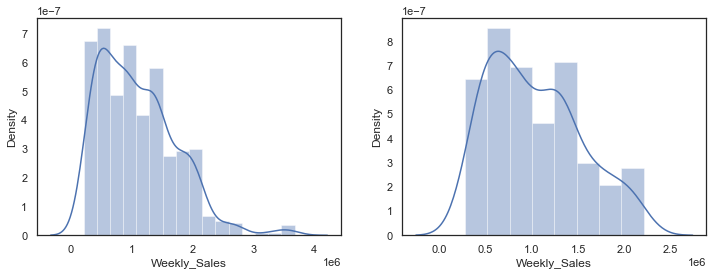

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [403]:
# submission.to_csv('./Data/submission5.csv', index=False)

## 쇼핑몰 지점별 모델 생성

`-` 쇼핑몰마다 주간 매출액의 분포가 상이하여 비슷한 분포를 띄는 쇼핑몰끼리 그룹화하려고 했다

`-` 그런데 굳이 그룹화 하지않고 쇼핑몰 지점에 따른 모델을 생성하여 학습하고자 했다 

`-` 원핫인코딩을 사용하면 피쳐의 개수가 너무 많아져서 쇼핑몰 지점마다 모델을 생성

`-` 기존의 존재하지 않는 새로운 쇼핑몰이라면 전체 데이터로 학습시킨 모델을 사용했다

`-` 그러나 test 데이터에서 새로운 쇼핑몰은 등장하지 않았다

In [160]:
k = 10
skfold1 = StratifiedKFold(k, shuffle=True, random_state=SEED)
skfold2 = StratifiedKFold(k, shuffle=True, random_state=SEED*2)

In [156]:
CB = CatBoostRegressor(use_best_model=True,
                       random_state=SEED,
                       #min_data_in_leaf=,
                       verbose=0)

In [114]:
XGB = XGBRegressor(random_state=SEED)

In [105]:
LGBM = LGBMRegressor(n_estimators=3000,
                     learning_rate=0.03,
                     #max_depth=7,
                     min_child_samples=3,
                     random_state=SEED)

`-` XGB 기본: 88841, CB 기본: 81941

In [161]:
valid_RMSE = []
preds = {}
model = CB
for store in tqdm(range(1, 46)):
    df3 = df.query('Store == @store')
    target = df3['Weekly_Sales']
    df3 = df3[features].drop('Store', axis=1)
    test3 = test2.query('Store == @store')
    test3 = test3[features].drop('Store', axis=1)
    _, model_valid_RMSE, model_test_pred = OOF_predict(model, df3, target, test3, skfold1, stratify='Month')
    _, model_valid_RMSE2, model_test_pred2 = OOF_predict(model, df3, target, test3, skfold2, stratify='Month')
    valid_RMSE.extend(model_valid_RMSE + model_valid_RMSE2)
    preds[store] = (model_test_pred + model_test_pred2) / 2
    print(f'{store} -> Mean: {np.mean(model_valid_RMSE + model_valid_RMSE2)} Std: {np.std(model_valid_RMSE + model_valid_RMSE2)}')
    
print(f'쇼핑몰 지점별 RMSE의 평균: {np.mean(valid_RMSE)}')

  2%|█▊                                                                                 | 1/45 [00:16<12:18, 16.78s/it]Custom logger is already specified. Specify more than one logger at same time is not thread safe.

1 -> Mean: 92399.62244787162 Std: 32255.08579434099


  4%|███▋                                                                               | 2/45 [00:35<12:39, 17.66s/it]

2 -> Mean: 130693.81390829319 Std: 52849.66247429799


  7%|█████▌                                                                             | 3/45 [00:50<11:30, 16.44s/it]

3 -> Mean: 30041.70263627616 Std: 12524.70719919756


  9%|███████▍                                                                           | 4/45 [01:07<11:34, 16.95s/it]

4 -> Mean: 140516.62957566913 Std: 59684.1878609802


 11%|█████████▏                                                                         | 5/45 [01:25<11:31, 17.30s/it]

5 -> Mean: 25733.874538612734 Std: 12825.178055276458


 13%|███████████                                                                        | 6/45 [01:44<11:37, 17.88s/it]

6 -> Mean: 128686.12041699099 Std: 50843.5844767931


 16%|████████████▉                                                                      | 7/45 [02:06<12:10, 19.21s/it]

7 -> Mean: 64335.08788986372 Std: 22667.65537709565


 18%|██████████████▊                                                                    | 8/45 [02:21<11:04, 17.95s/it]

8 -> Mean: 68649.62003445665 Std: 23517.105669533066


 20%|████████████████▌                                                                  | 9/45 [02:39<10:46, 17.95s/it]

9 -> Mean: 43728.41216458818 Std: 16264.006400706288


 22%|██████████████████▏                                                               | 10/45 [02:54<09:55, 17.02s/it]

10 -> Mean: 179593.3656150484 Std: 66149.47603678997


 24%|████████████████████                                                              | 11/45 [03:13<09:54, 17.48s/it]

11 -> Mean: 95668.69511788378 Std: 32187.682741488687


 27%|█████████████████████▊                                                            | 12/45 [03:30<09:31, 17.32s/it]

12 -> Mean: 85624.63017385991 Std: 37878.730634013315


 29%|███████████████████████▋                                                          | 13/45 [03:46<09:00, 16.90s/it]

13 -> Mean: 154066.99094669716 Std: 65494.40914766161


 31%|█████████████████████████▌                                                        | 14/45 [04:04<08:53, 17.22s/it]

14 -> Mean: 183120.20089165575 Std: 69590.9259812939


 33%|███████████████████████████▎                                                      | 15/45 [04:23<08:59, 18.00s/it]

15 -> Mean: 67310.71885004608 Std: 35412.1700321815


 36%|█████████████████████████████▏                                                    | 16/45 [04:42<08:47, 18.19s/it]

16 -> Mean: 43493.74758700369 Std: 13283.457252194907


 38%|██████████████████████████████▉                                                   | 17/45 [04:58<08:09, 17.48s/it]

17 -> Mean: 83234.97321157414 Std: 28263.094509654944


 40%|████████████████████████████████▊                                                 | 18/45 [05:17<08:01, 17.85s/it]

18 -> Mean: 108094.40124603869 Std: 41188.78394400978


 42%|██████████████████████████████████▌                                               | 19/45 [05:34<07:41, 17.74s/it]

19 -> Mean: 110868.23244452201 Std: 39259.90166951843


 44%|████████████████████████████████████▍                                             | 20/45 [05:51<07:15, 17.43s/it]

20 -> Mean: 165492.58875657964 Std: 61415.72442340248


 47%|██████████████████████████████████████▎                                           | 21/45 [06:09<07:02, 17.62s/it]

21 -> Mean: 73226.47634071394 Std: 34444.92546331088


 49%|████████████████████████████████████████                                          | 22/45 [06:32<07:20, 19.14s/it]

22 -> Mean: 94485.36049030251 Std: 39248.58456372745


 51%|█████████████████████████████████████████▉                                        | 23/45 [06:52<07:10, 19.59s/it]

23 -> Mean: 141255.22833678962 Std: 45393.962462650685


 53%|███████████████████████████████████████████▋                                      | 24/45 [07:13<07:01, 20.08s/it]

24 -> Mean: 96879.96333867239 Std: 32788.10020723747


 56%|█████████████████████████████████████████████▌                                    | 25/45 [07:33<06:35, 19.78s/it]

25 -> Mean: 65135.54860314756 Std: 30073.25022483932


 58%|███████████████████████████████████████████████▍                                  | 26/45 [07:56<06:34, 20.78s/it]

26 -> Mean: 58378.81149676363 Std: 20651.022860787005


 60%|█████████████████████████████████████████████████▏                                | 27/45 [08:20<06:32, 21.82s/it]

27 -> Mean: 158408.72531237968 Std: 52841.24370837473


 62%|███████████████████████████████████████████████████                               | 28/45 [08:40<06:04, 21.43s/it]

28 -> Mean: 106922.98895823487 Std: 41028.392711108136


 64%|████████████████████████████████████████████████████▊                             | 29/45 [09:03<05:46, 21.67s/it]

29 -> Mean: 62337.81974202226 Std: 31759.81019400406


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [09:30<05:50, 23.37s/it]

30 -> Mean: 14550.97201122918 Std: 4272.805616911951


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [09:50<05:11, 22.24s/it]

31 -> Mean: 75072.77059577813 Std: 34155.20270470351


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [10:08<04:34, 21.12s/it]

32 -> Mean: 82538.89880783363 Std: 35738.77649081468


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [10:35<04:33, 22.82s/it]

33 -> Mean: 10866.499099688108 Std: 3475.66649740669


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [10:53<03:54, 21.28s/it]

34 -> Mean: 59768.543831724885 Std: 26687.032681363344


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [11:18<03:44, 22.49s/it]

35 -> Mean: 121999.0610684567 Std: 62137.61398949109


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [11:44<03:31, 23.51s/it]

36 -> Mean: 15731.458475885676 Std: 4027.3270818453784


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [12:03<02:57, 22.20s/it]

37 -> Mean: 16602.61556714024 Std: 4911.9992090571905


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [12:26<02:38, 22.59s/it]

38 -> Mean: 13984.525884368104 Std: 3923.5560102653003


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [12:48<02:13, 22.29s/it]

39 -> Mean: 123963.37388885964 Std: 57933.87805512789


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [13:13<01:55, 23.02s/it]

40 -> Mean: 58123.78249084372 Std: 17276.218132145103


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [13:33<01:29, 22.29s/it]

41 -> Mean: 108465.69343409556 Std: 49408.01621836094


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [14:00<01:10, 23.57s/it]

42 -> Mean: 20508.50071734447 Std: 5160.553885933238


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [14:25<00:47, 23.96s/it]

43 -> Mean: 23869.651898921908 Std: 5838.076274425927


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [14:45<00:22, 22.73s/it]

44 -> Mean: 11829.00367826202 Std: 3672.0565864569658


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [15:06<00:00, 20.16s/it]

45 -> Mean: 71124.87250373316 Std: 31820.8424969761
쇼핑몰 지점별 RMSE의 평균: 81941.87944503828


In [162]:
predictions = pd.DataFrame(data=preds[1])
for i in range(2, 46):
    predictions = predictions.append(pd.DataFrame(data=preds[i]))
predictions = predictions.reset_index().drop('index', axis=1).rename(columns={0:'target'})

In [163]:
submission['Weekly_Sales'] = predictions['target'] 

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

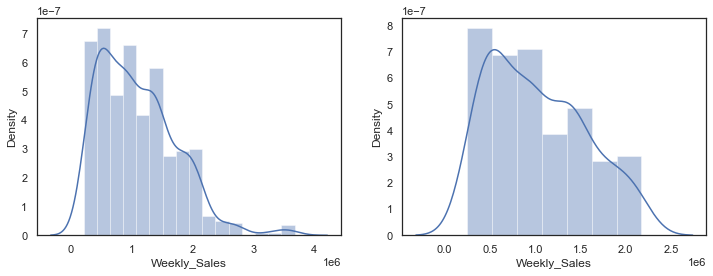

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [166]:
# submission.to_csv('./Data/submission16.csv', index=False)